In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
import seaborn as sb
from yellowbrick.regressor import ResidualsPlot

In [400]:
def setup_plot(title, width=10, height=7):
    plt.figure(figsize=(width, height))
    plt.title(title, fontsize=15)
     
def plot_residuals(model, x_train, x_test, y_train, y_test):
    visualizer = ResidualsPlot(model)

    visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof() 
    
def adf_test(y):
    '''
    Perform Augmented Dickey Fuller test, for stationarity.
    '''
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

### Preprocess Data
    We read in the dataset as a time series, and drop outliers in our dataset. 
    
    We also make both time series stationary. It is important to impose the requirement of stationarity because a stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Then, it is relatively easy to predict: One can predict that its statistical properties will be the same in the future as they have been in the past.

In [403]:
# ------------------ Read and Process Data ------------------ #

# I am replacing outliers instead of dropping for sake of window
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

# Remove outliers via dropping
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan

sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan

df.dropna(inplace=True)

# ------------- Make Time Series Stationary ------------- #
# We would like to make the series stationary, for many properties
# that hold for independent variables also hold for stationary ones.

# sliding window size to simulate 2 weeks ( 10 days )
window = 10

# Log transformation
sig_log = np.log(df['signal'])
price_log = np.log(df['spy_close_price'])

# Expotential Weighted Moving average for log transformed:
# Weights are assigned to all the previous values with a decay factor. 
sig_expw_avg = sig_log.ewm(halflife=window, min_periods=0, adjust=True, ignore_na=False).mean()
price_expw_avg = price_log.ewm(halflife=window, min_periods=0, adjust=True, ignore_na=False).mean()

sig_ewma_diff = sig_log - sig_expw_avg
price_ewma_diff = price_log - price_expw_avg

# The stationary series.
sig_dif = sig_ewma_diff
price_dif = price_ewma_diff

# Confirm the stationarity. We reject the null hypothesis
# that there is a unit root (nonstationary variable)
sad = adfuller(sig_dif)
pad = adfuller(price_dif)
print('Augmented Dickey-Fuller test:')
print('Critical values: ', sad[4])
print('signal test statistic: ', sad[0])
print('stockprice test statistic: ', pad[0])

# Data frame with stationary series
df_data = pd.concat([sig_dif, price_dif], axis=1)
df_data.dropna(inplace=True) 

Augmented Dickey-Fuller test:
Critical values:  {'1%': -3.4403577332291282, '5%': -2.8659559257802867, '10%': -2.5691216494088338}
signal test statistic:  -6.2255000408
stockprice test statistic:  -6.21902012536


### Linear Regression
    Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable.

Coefficients: 
 [[ 40.55166251]]
Mean squared error: 4.6963862
R-squared = : 0.9893544


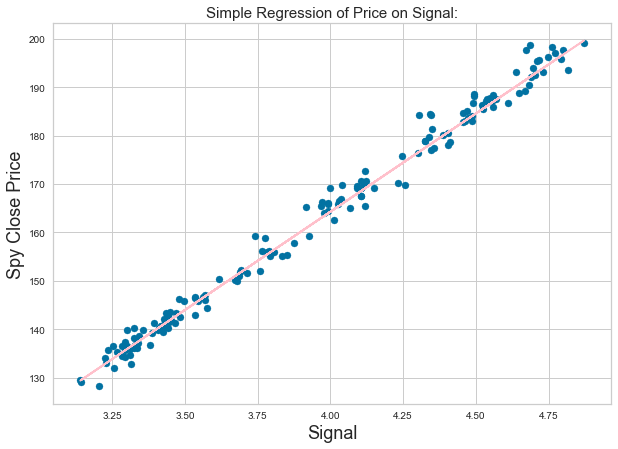

In [404]:
# Use 80% of data as training, and 20% for test
div = int(len(df)*0.80)

# No need for stationarity here
X = df[['signal']]
Y = df[['spy_close_price']]
X_train, X_test , y_train , y_test = train_test_split(X,Y,test_size=0.25,random_state=34)

# Train the model and predict for x_test
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
expected = y_test

# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.7f"
      % mean_squared_error(y_true=expected, y_pred=predicted))
# Explained variance score: 1 is perfect prediction
print('R-squared = : %.7f' % r2_score(y_true=expected, y_pred=predicted))

setup_plot("Simple Regression of Price on Signal:")
plt.scatter(X_test, y_test)
plt.plot(X_test, predicted, color='pink')

plt.xlabel('Signal', fontsize=18)
plt.ylabel('Spy Close Price', fontsize=18)

plt.show()


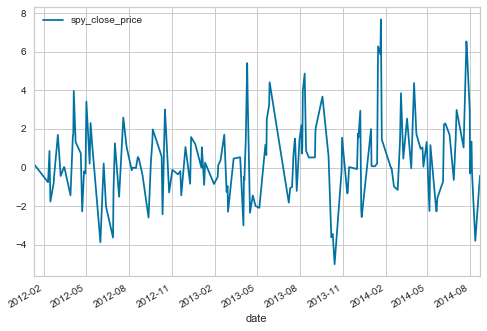

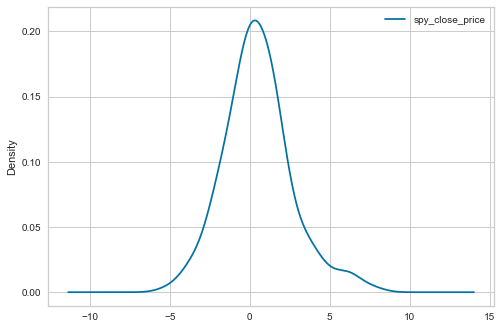

       spy_close_price
count       165.000000
mean          0.500716
std           2.114894
min          -5.011813
25%          -0.805347
50%           0.286397
75%           1.550634
max           7.678716


In [405]:
# Residuals

residuals = pd.DataFrame(expected-predicted)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

    We seek a random distributed residual plot. 
    
    From the above residual description, the mean = ~0.0. 
    A non zero mean indicates bias in the prediction, and trend
    that has not been captured by the model.

    The mean score above indicates our current model captures 
    the trend from X (signal).

### Forecasting spy_close_price via Autoregression
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

    Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It models an output value based on a linear combination of input values, where the input variables are observations at previous steps. Autocorrelation is the assumption that variables at previous steps are userful for predicting the next step.

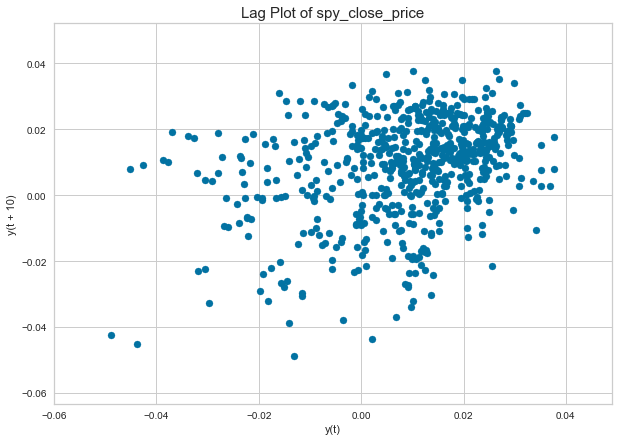

In [407]:
# First, to verify that autocorrelation exits in stock price.
# The clustering in the graph indicates autocorrelation does.
setup_plot("Lag Plot of spy_close_price")
lag_plot(df_data['spy_close_price'], lag = window)
plt.show() 


Optimal Lag: 18.00

Test MSE: 0.0000415


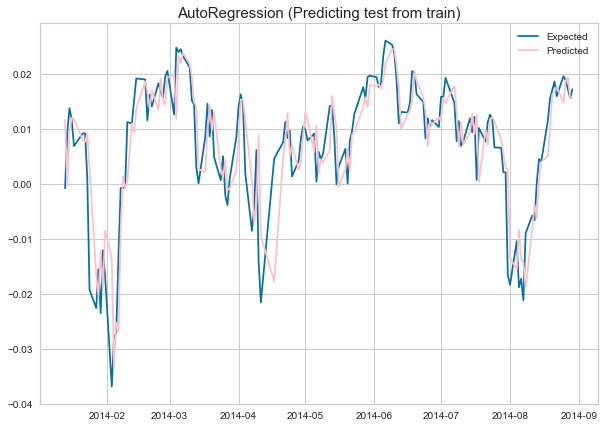

In [436]:
# split dataset, test_start=index where test starts
# Note: we are using the stationary data
X = df_data['spy_close_price']
test_start = 500
train, test = X[1:test_start], X[test_start:]
test_index = X[test_start:].index

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar # lag
coef = model_fit.params

# walk forward over time steps in test aka start.
# predicting for X[test_start:] using the steps=window behind it.

# Use the learned coefficients and manually make predictions. 
# This requires that the history of 29 prior observations be kept 
# and that the coefficients be retrieved from the model and used 
# in the regression equation to come up with new forecasts.

history = train[test_start-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))


print('\nOptimal Lag: %.2f' % model_fit.k_ar)

error = mean_squared_error(test, predictions)
print('\nTest MSE: %.7f' % error)

# Make a dataframe out of the predictions, for plotting purposes
df_pred = pd.DataFrame(index=test_index, 
                       data=predictions, 
                       columns=['price_prediction'])

setup_plot("AutoRegression (Predicting test from train)")
plt.plot(test, label='Expected')
plt.plot(df_pred['price_prediction'], color='pink', label='Predicted')
plt.legend()
plt.show() 

    Note the lag value from training the data is 18. 
    18 is roughly ~ 4 weeks of previous stocks.

I think my linear regression one is wrong,
why is the correlation so high.